In [23]:
import numpy as np
from src.cyc_gbm import CycGBM, CycGLM
from src.cyc_gbm.utils import tune_kappa, train_test_split
from src.cyc_gbm.distributions import initiate_distribution
from matplotlib import pyplot as plt
import pandas as pd

In [24]:
# Simulation parameters
n = 10000
p = 9
dist = "normal"
simulation_seed = 10
cv_seed = 11


def parameter_function(X):
    z0 = (
        1.5 * X[:, 1]
        + 2 * X[:, 3]
        - 0.65 * X[:, 2] ** 2
        + 0.5 * np.abs(X[:, 3]) * np.sin(0.5 * X[:, 2])
        + 0.45 * X[:, 4] * X[:, 5] ** 2
    )
    z1 = 1 + 0.02 * X[:, 2] + 0.5 * X[:, 1] * (X[:, 1] < 2) + 1.8 * (X[:, 5] > 0)
    return np.stack([z0, z1])


# GBM hyperparameters
kappa_max = 250
eps_gbm = 0.1
max_depth = 3
min_samples_leaf = 5
n_splits = 10

# GLM hyperparameters
max_iter = 100000
eps_glm = 1e-8
tol = 1e-4

## Simulate data

In [25]:
rng = np.random.default_rng(seed=simulation_seed)
X = np.concatenate([np.ones((1, n)), rng.normal(0, 1, (p - 1, n))]).T
w = rng.choice([1, 3, 5, 10], p=[0.4, 0.3, 0.2, 0.1], size=n)

distribution = initiate_distribution(dist=dist)
z = parameter_function(X)
y = distribution.simulate(z=z, w=w, rng=rng)
X_train, X_test, y_train, y_test, z_train, z_test, w_train, w_test = train_test_split(
    X=X, y=y, z=z, w=w, test_size=0.2, rng=rng
)
z_hat = {
    data_set: {
        model: None for model in ["intercept", "glm", "uni-gbm", "cyc-gbm", "true"]
    }
    for data_set in ["train", "test"]
}

z_hat["train"]["true"] = z_train
z_hat["test"]["true"] = z_test

In [26]:
def moving_average(y, window_size=100):
    return np.convolve(y, np.ones(window_size), "full") / window_size


def moving_variance(y, z, w, window_size):
    r = y - distribution.moment(z=z, w=w, k=1)
    return np.convolve(r**2, np.ones(window_size), "full") / window_size


def moving_moment(y, window_size, z, w, k):
    if k == 1:
        return moving_average(y, window_size)
    elif k == 2:
        return moving_variance(y, z=z, w=w, window_size=window_size)

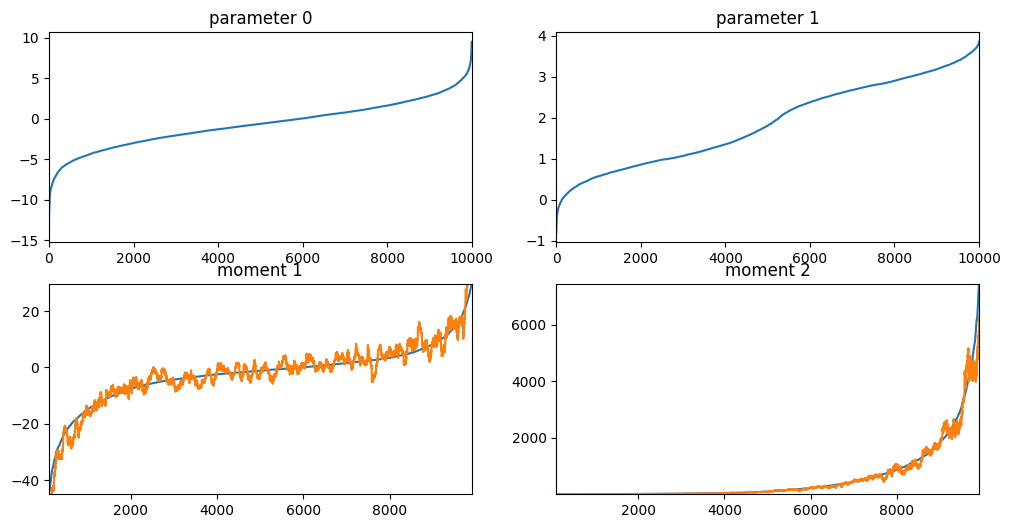

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

# parameters
for j in range(distribution.d):
    axs[j].set_title(f"parameter {j}")
    sort_order = np.argsort(z[j])
    axs[j].plot(z[j][sort_order])

# moments
window_size = 100
for k in [1, 2]:
    axs[k + 1].set_title(f"moment {k}")
    moment = distribution.moment(z=z, w=w, k=k)
    sort_order = np.argsort(moment)

    moment_empirical = moving_moment(
        y[sort_order], window_size=window_size, z=z[:, sort_order], w=w[sort_order], k=k
    )
    axs[k + 1].plot(moment[sort_order], label="true")
    axs[k + 1].plot(moment_empirical, label="empirical")
    axs[k + 1].set_xlim([window_size, -window_size])
    axs[k + 1].set_ylim(
        [
            min(moment[sort_order][window_size:-window_size]),
            max(moment[sort_order][window_size:-window_size]),
        ]
    )

In [ ]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, distribution.d)

# Parameter estimates
for j in range(distribution.d):
    ax = fig.add_subplot(gs[0, j])
    ax.set_title(f"parameter {j}")
    sort_order = np.argsort(z[j])
    ax.plot(z[j][sort_order])

# Moment estimates
window_size = 100
for k in [1, 2]:
    ax = fig.add_subplot(gs[1, k - 1])
    ax.set_title(f"moment {k}")

    moment = distribution.moment(z=z, w=w, k=k)
    sort_order = np.argsort(moment)
    moment_empirical = moving_moment(
        y[sort_order], window_size=window_size, z=z[:, sort_order], w=w[sort_order], k=k
    )
    ax.plot(moment[sort_order], label="true")
    ax.plot(moment_empirical, label="empirical")
    # ax.set_xlim([window_size, len(y) - window_size])
    # ax.set_ylim(
    #    [
    #        min(moment[sort_order][window_size : len(y) - -window_size]),
    #        max(moment[sort_order][window_size : len(y) - -window_size]),
    #    ]
    # )

In [28]:
min(moment[sort_order][window_size:-window_size]), max(
    moment[sort_order][window_size:-window_size]
),

## Intercept

In [29]:
z0 = distribution.mle(y=y_train, w=w_train)[:, None]
z_hat["train"]["intercept"] = np.tile(z0, (1, len(y_train)))
z_hat["test"]["intercept"] = np.tile(z0, (2, len(y_test)))

## Cyclical GLM

In [30]:
glm = CycGLM(dist="normal", eps=eps_glm, max_iter=max_iter, tol=tol)

glm.fit(X=X_train, y=y_train, w=w_train)

z_hat["train"]["glm"] = glm.predict(X_train)
z_hat["test"]["glm"] = glm.predict(X_test)

2023-05-10 08:31:36,027 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 10-fold cross-validation
INFO:src.cyc_gbm.utils:Starting tuning of kappa with 10-fold cross-validation
2023-05-10 08:31:36,033 - src.cyc_gbm.utils - INFO - Fold 1/10
INFO:src.cyc_gbm.utils:Fold 1/10
2023-05-10 08:31:37,360 - src.cyc_gbm.utils - INFO - Fold 2/10
INFO:src.cyc_gbm.utils:Fold 2/10
2023-05-10 08:31:41,403 - src.cyc_gbm.utils - INFO - Fold 3/10
INFO:src.cyc_gbm.utils:Fold 3/10
2023-05-10 08:31:45,250 - src.cyc_gbm.utils - INFO - Fold 4/10
INFO:src.cyc_gbm.utils:Fold 4/10
2023-05-10 08:31:51,742 - src.cyc_gbm.utils - INFO - Fold 5/10
INFO:src.cyc_gbm.utils:Fold 5/10
2023-05-10 08:31:54,121 - src.cyc_gbm.utils - INFO - Fold 6/10
INFO:src.cyc_gbm.utils:Fold 6/10
2023-05-10 08:31:57,695 - src.cyc_gbm.utils - INFO - Fold 7/10
INFO:src.cyc_gbm.utils:Fold 7/10
2023-05-10 08:31:59,185 - src.cyc_gbm.utils - INFO - Fold 8/10
INFO:src.cyc_gbm.utils:Fold 8/10
2023-05-10 08:32:01,707 - src.cyc_gbm.utils - 

### Univariate GBM

In [31]:
# Tune kappa
kappa_uni = tune_kappa(
    X=X_train,
    y=y_train,
    w=w_train,
    n_splits=n_splits,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    kappa_max=[kappa_max, 0],
    dist=dist,
    random_state=cv_seed,
    verbose=1,
)["kappa"]

gbm_uni = CycGBM(
    kappa=kappa_uni,
    dist="normal",
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_uni.fit(X=X_train, y=y_train, w=w_train)

z_hat["train"]["uni-gbm"] = gbm_uni.predict(X_train)
z_hat["test"]["uni-gbm"] = gbm_uni.predict(X_test)

2023-05-10 08:32:17,170 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 10-fold cross-validation
INFO:src.cyc_gbm.utils:Starting tuning of kappa with 10-fold cross-validation
2023-05-10 08:32:17,188 - src.cyc_gbm.utils - INFO - Fold 1/10
INFO:src.cyc_gbm.utils:Fold 1/10
2023-05-10 08:32:48,224 - src.cyc_gbm.utils - INFO - Fold 2/10
INFO:src.cyc_gbm.utils:Fold 2/10
2023-05-10 08:33:17,072 - src.cyc_gbm.utils - INFO - Fold 3/10
INFO:src.cyc_gbm.utils:Fold 3/10
2023-05-10 08:33:41,492 - src.cyc_gbm.utils - INFO - Fold 4/10
INFO:src.cyc_gbm.utils:Fold 4/10
2023-05-10 08:34:17,032 - src.cyc_gbm.utils - INFO - Fold 5/10
INFO:src.cyc_gbm.utils:Fold 5/10
2023-05-10 08:34:58,865 - src.cyc_gbm.utils - INFO - Fold 6/10
INFO:src.cyc_gbm.utils:Fold 6/10
2023-05-10 08:35:35,492 - src.cyc_gbm.utils - INFO - Fold 7/10
INFO:src.cyc_gbm.utils:Fold 7/10
2023-05-10 08:36:19,105 - src.cyc_gbm.utils - INFO - Fold 8/10
INFO:src.cyc_gbm.utils:Fold 8/10
2023-05-10 08:36:54,855 - src.cyc_gbm.utils - 

#### Cyclical GBM

In [32]:
kappa_cyc = tune_kappa(
    X=X_train,
    y=y_train,
    w=w_train,
    n_splits=n_splits,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    kappa_max=kappa_max,
    dist=dist,
    random_state=cv_seed,
    verbose=1,
)["kappa"]

gbm_cyc = CycGBM(
    kappa=kappa_cyc,
    dist="normal",
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_cyc.fit(X=X_train, y=y_train, w=w_train)

z_hat["train"]["cyc-gbm"] = gbm_cyc.predict(X_train)
z_hat["test"]["cyc-gbm"] = gbm_cyc.predict(X_test)

boosting steps:
         kappa_0  kappa_1
uni-gbm       25        0
cyc-gbm       64       51

losses:
           train   test
intercept  3.776  3.762
glm        3.453  3.478
uni-gbm    3.722  3.735
cyc-gbm    2.999  3.073
true       3.016  3.031


## Results

In [32]:
# Tuning results
kappas = pd.DataFrame(
    columns=[f"kappa_{j}" for j in range(0, distribution.d)],
    index=["uni-gbm", "cyc-gbm"],
    dtype=int,
)
kappas.loc["uni-gbm", :] = kappa_uni
kappas.loc["cyc-gbm", :] = kappa_cyc

print("boosting steps:")
print(kappas.astype(int))

# Losses
losses = pd.DataFrame(
    columns=["train", "test"],
    index=z_hat["train"].keys(),
    dtype=float,
)
for data_set, y_set, w_set in [("train", y_train, w_train), ("test", y_test, w_test)]:
    for model in z_hat[data_set].keys():
        losses.loc[model, data_set] = distribution.loss(
            y=y_set, z=z_hat[data_set][model], w=w_set
        ).mean()
print("\nlosses:")
print(losses.round(3))

In [ ]:
# Plot parameter estimates
fig, axs = plt.subplots(
    ncols=distribution.d,
    nrows=2,
    gridspec_kw={"width_ratios": [distribution.d] * distribution.d + [2] * 2},
    figsize=(10, 6),
)
axs = axs.flatten()

for j in range(distribution.d):
    axs[j].set_title(f"parameter {j}")
    sort_order = np.argsort(z_hat["test"]["true"][j])
    for model in z_hat["train"].keys():
        axs[j].plot(z_hat["test"][model][j][sort_order], label=model)

axs[0].legend();

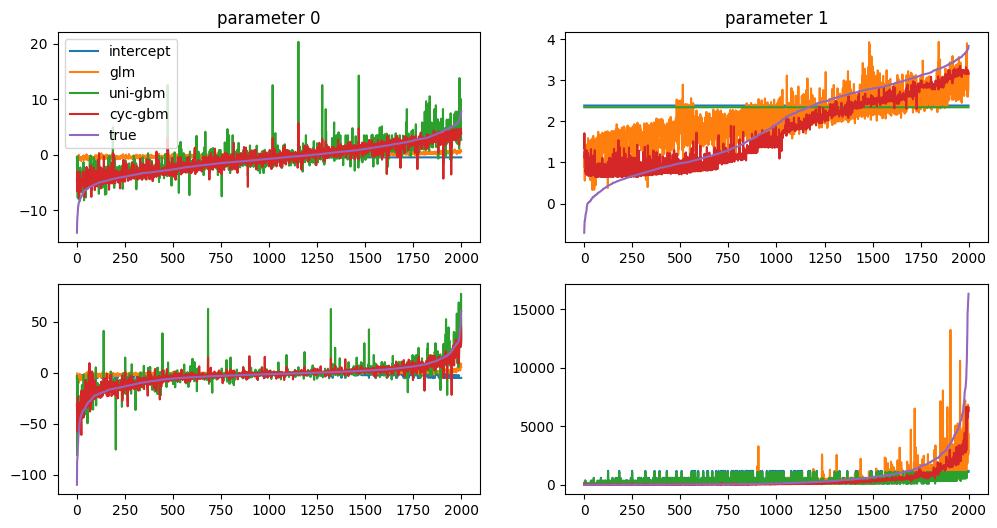

In [61]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, distribution.d)

# Parameter estimates
for j in range(distribution.d):
    ax = fig.add_subplot(gs[0, j])
    ax.set_title(f"parameter {j}")
    sort_order = np.argsort(z_hat["test"]["true"][j])
    for model in z_hat["train"].keys():
        ax.plot(z_hat["test"][model][j][sort_order], label=model)
    if j == 0:
        ax.legend()

# Moment estimates
for k in [1, 2]:
    ax = fig.add_subplot(gs[1, k - 1])
    sort_order = np.argsort(distribution.moment(z=z_hat["test"]["true"], w=w_test, k=k))
    for model in z_hat["train"].keys():
        ax.plot(
            distribution.moment(z=z_hat["test"][model], w=w_test, k=k)[sort_order],
            label=model,
        )

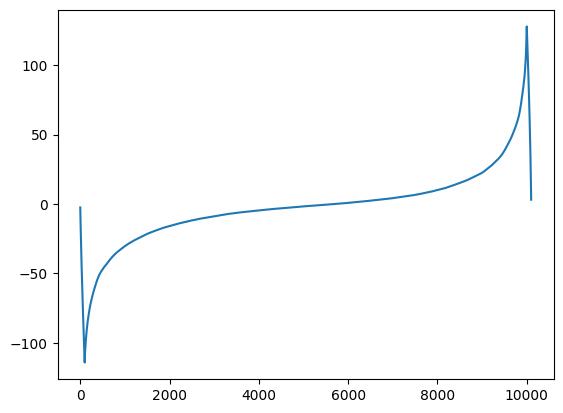

In [53]:
sort_order = np.argsort(y)
plt.plot(
    moving_average(y[sort_order], window_size=window_size)[window_size:-window_size],
    label="y",
)